In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

In [2]:
"""
Here we load the dataset, add gaussian,poisson,speckle

    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
                
We define a function that adds each noise when called from main function
Input & Output: np array
                
"""


def add_noise(img,noise_type="gaussian"):
  
  row,col=28,28
  img=img.astype(np.float32)
  
  if noise_type=="gaussian":
    mean=0
    var=10
    sigma=var**.5
    noise=np.random.normal(-5.9,5.9,img.shape)
    noise=noise.reshape(row,col)
    img=img+noise
    return img

  if noise_type=="speckle":
    noise=np.random.randn(row,col)
    noise=noise.reshape(row,col)
    img=img+img*noise
    return img

In [3]:
#Here we load the dataset from keras
(xtrain,ytrain),(xtest,ytest)=mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain),len(xtest)))

11501568/11490434 [==============================] - 0s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [4]:
"""
From here onwards,we split the 60k training datapoints into 3 sets each given one type of each noise.
We shuffle them for better generalization.
"""
noises=["gaussian","speckle"]
noise_ct=0
noise_id=0
traindata=np.zeros((60000,28,28))

In [5]:
for idx in tqdm(range(len(xtrain))):
  
  if noise_ct<(len(xtrain)/2):
    noise_ct+=1
    traindata[idx]=add_noise(xtrain[idx],noise_type=noises[noise_id])
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id])) 

 55%|█████▍    | 32855/60000 [00:02<00:01, 16596.86it/s]


gaussian noise addition completed to images


100%|██████████| 60000/60000 [00:03<00:00, 16274.65it/s]


speckle noise addition completed to images


In [6]:
noise_ct=0
noise_id=0
testdata=np.zeros((10000,28,28))

for idx in tqdm(range(len(xtest))):
  
  if noise_ct<(len(xtest)/2):
    noise_ct+=1
    x=add_noise(xtest[idx],noise_type=noises[noise_id])
    testdata[idx]=x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id]))    
  

 79%|███████▉  | 7920/10000 [00:00<00:00, 15956.69it/s]


gaussian noise addition completed to images


100%|██████████| 10000/10000 [00:00<00:00, 15804.91it/s]


speckle noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

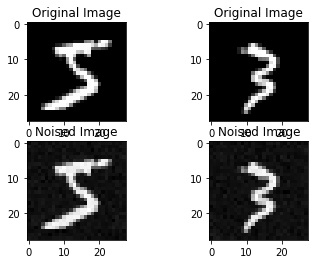

In [7]:
"""
Here we Try to visualize, each type of noise that was introduced in the images
Along with their original versions

"""

f, axes=plt.subplots(2,2)

#showing images with gaussian noise
axes[0,0].imshow(xtrain[0],cmap="gray")
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0],cmap='gray')
axes[1,0].set_title("Noised Image")

#showing images with speckle noise
axes[0,1].imshow(xtrain[25000],cmap='gray')
axes[0,1].set_title("Original Image")
axes[1,1].imshow(traindata[25000],cmap="gray")
axes[1,1].set_title("Noised Image")



In [8]:
class noisedDataset(Dataset):
  
  def __init__(self,datasetnoised,datasetclean,labels,transform):
    self.noise=datasetnoised
    self.clean=datasetclean
    self.labels=labels
    self.transform=transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self,idx):
    xNoise=self.noise[idx]
    xClean=self.clean[idx]
    y=self.labels[idx]
    
    if self.transform != None:
      xNoise=self.transform(xNoise)
      xClean=self.transform(xClean)
      
    
    return (xNoise,xClean,y)
      
  
    

In [9]:
tsfms=transforms.Compose([
    transforms.ToTensor()
])

trainset=noisedDataset(traindata,xtrain,ytrain,tsfms)
testset=noisedDataset(testdata,xtest,ytest,tsfms)

In [10]:
"""
Here , we create the trainloaders and testloaders.
Also, we transform the images using standard lib functions
"""


batch_size=32



trainloader=DataLoader(trainset,batch_size=32,shuffle=True)
testloader=DataLoader(testset,batch_size=1,shuffle=True)



In [11]:
"""
Here, we define the autoencoder model.
"""

class denoising_model(nn.Module):
  def __init__(self):
    super(denoising_model,self).__init__()
    self.encoder=nn.Sequential(
                  nn.Linear(28*28,256),
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,64),
                  nn.ReLU(True)
        
                  )
    
    self.decoder=nn.Sequential(
                  nn.Linear(64,128),
                  nn.ReLU(True),
                  nn.Linear(128,256),
                  nn.ReLU(True),
                  nn.Linear(256,28*28),
                  nn.Sigmoid(),
                  )
    
 
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    
    return x
  

In [44]:
"""
Here, we define the quantized autoencoder model.
"""

class denoising_model_q(nn.Module):
  def __init__(self):
    super(denoising_model_q,self).__init__()
    self.quant = torch.quantization.QuantStub()
    self.dequant = torch.quantization.DeQuantStub()
    self.encoder=nn.Sequential(
                  nn.Linear(28*28,256),
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,64),
                  nn.ReLU(True)
        
                  )
    
    self.decoder=nn.Sequential(
                  nn.Linear(64,128),
                  nn.ReLU(True),
                  nn.Linear(128,256),
                  nn.ReLU(True),
                  nn.Linear(256,28*28),
                  nn.Sigmoid(),
                  )
    
 
  def forward(self,x):
    x = self.quant(x)
    x=self.encoder(x)
    x=self.decoder(x)
    x=self.dequant(x)
    
    return x
  

In [91]:
#We check whether cuda is available and choose device accordingly
if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"
  
model=denoising_model().to(device)
criterion=nn.MSELoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)

In [92]:
epochs=120
l=len(trainloader)
losslist=list()
epochloss=0
running_loss=0
for epoch in range(epochs):
  
  print("Entering Epoch: ",epoch)
  for dirty,clean,label in tqdm((trainloader)):
    
    
    dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
    clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
    dirty,clean=dirty.to(device),clean.to(device)
    
    
    
    #-----------------Forward Pass----------------------
    output=model(dirty)
    loss=criterion(output,clean)
    #-----------------Backward Pass---------------------
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss+=loss.item()
    epochloss+=loss.item()
  #-----------------Log-------------------------------
  losslist.append(running_loss/l)
  running_loss=0
  print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))
    
    
      
      
    

 

Entering Epoch:  0


100%|██████████| 1875/1875 [00:08<00:00, 211.39it/s]


======> epoch: 0/120, Loss:0.07227866351604462
Entering Epoch:  1


100%|██████████| 1875/1875 [00:08<00:00, 211.93it/s]


======> epoch: 1/120, Loss:0.0630289688706398
Entering Epoch:  2


100%|██████████| 1875/1875 [00:08<00:00, 208.52it/s]


======> epoch: 2/120, Loss:0.06534122675657272
Entering Epoch:  3


100%|██████████| 1875/1875 [00:08<00:00, 209.95it/s]


======> epoch: 3/120, Loss:0.06047489121556282
Entering Epoch:  4


100%|██████████| 1875/1875 [00:09<00:00, 208.24it/s]


======> epoch: 4/120, Loss:0.06568524241447449
Entering Epoch:  5


100%|██████████| 1875/1875 [00:08<00:00, 211.47it/s]


======> epoch: 5/120, Loss:0.05729394778609276
Entering Epoch:  6


100%|██████████| 1875/1875 [00:08<00:00, 209.93it/s]


======> epoch: 6/120, Loss:0.058519426733255386
Entering Epoch:  7


100%|██████████| 1875/1875 [00:08<00:00, 213.79it/s]


======> epoch: 7/120, Loss:0.054537154734134674
Entering Epoch:  8


100%|██████████| 1875/1875 [00:08<00:00, 216.92it/s]


======> epoch: 8/120, Loss:0.04909344017505646
Entering Epoch:  9


100%|██████████| 1875/1875 [00:08<00:00, 212.51it/s]


======> epoch: 9/120, Loss:0.05489613860845566
Entering Epoch:  10


100%|██████████| 1875/1875 [00:08<00:00, 216.26it/s]


======> epoch: 10/120, Loss:0.04984908178448677
Entering Epoch:  11


100%|██████████| 1875/1875 [00:08<00:00, 218.02it/s]


======> epoch: 11/120, Loss:0.05266733467578888
Entering Epoch:  12


100%|██████████| 1875/1875 [00:08<00:00, 215.40it/s]


======> epoch: 12/120, Loss:0.04914776235818863
Entering Epoch:  13


100%|██████████| 1875/1875 [00:08<00:00, 215.25it/s]


======> epoch: 13/120, Loss:0.05088423937559128
Entering Epoch:  14


100%|██████████| 1875/1875 [00:08<00:00, 218.08it/s]


======> epoch: 14/120, Loss:0.04135235771536827
Entering Epoch:  15


100%|██████████| 1875/1875 [00:08<00:00, 216.78it/s]


======> epoch: 15/120, Loss:0.04060323163866997
Entering Epoch:  16


100%|██████████| 1875/1875 [00:08<00:00, 214.93it/s]


======> epoch: 16/120, Loss:0.04102082550525665
Entering Epoch:  17


100%|██████████| 1875/1875 [00:08<00:00, 219.71it/s]


======> epoch: 17/120, Loss:0.046071697026491165
Entering Epoch:  18


100%|██████████| 1875/1875 [00:08<00:00, 215.14it/s]


======> epoch: 18/120, Loss:0.04065748676657677
Entering Epoch:  19


100%|██████████| 1875/1875 [00:08<00:00, 213.61it/s]


======> epoch: 19/120, Loss:0.04060865938663483
Entering Epoch:  20


100%|██████████| 1875/1875 [00:08<00:00, 217.17it/s]


======> epoch: 20/120, Loss:0.03618404269218445
Entering Epoch:  21


100%|██████████| 1875/1875 [00:08<00:00, 213.18it/s]


======> epoch: 21/120, Loss:0.03823264688253403
Entering Epoch:  22


100%|██████████| 1875/1875 [00:08<00:00, 213.32it/s]


======> epoch: 22/120, Loss:0.0410638228058815
Entering Epoch:  23


100%|██████████| 1875/1875 [00:08<00:00, 215.66it/s]


======> epoch: 23/120, Loss:0.040018465369939804
Entering Epoch:  24


100%|██████████| 1875/1875 [00:08<00:00, 219.65it/s]


======> epoch: 24/120, Loss:0.03563903272151947
Entering Epoch:  25


100%|██████████| 1875/1875 [00:08<00:00, 218.21it/s]


======> epoch: 25/120, Loss:0.036333389580249786
Entering Epoch:  26


100%|██████████| 1875/1875 [00:08<00:00, 217.95it/s]


======> epoch: 26/120, Loss:0.035179443657398224
Entering Epoch:  27


100%|██████████| 1875/1875 [00:08<00:00, 217.53it/s]


======> epoch: 27/120, Loss:0.0367259681224823
Entering Epoch:  28


100%|██████████| 1875/1875 [00:08<00:00, 215.31it/s]


======> epoch: 28/120, Loss:0.03416116535663605
Entering Epoch:  29


100%|██████████| 1875/1875 [00:08<00:00, 214.97it/s]


======> epoch: 29/120, Loss:0.036481183022260666
Entering Epoch:  30


100%|██████████| 1875/1875 [00:08<00:00, 215.79it/s]


======> epoch: 30/120, Loss:0.03277468681335449
Entering Epoch:  31


100%|██████████| 1875/1875 [00:08<00:00, 214.24it/s]


======> epoch: 31/120, Loss:0.037275176495313644
Entering Epoch:  32


100%|██████████| 1875/1875 [00:08<00:00, 213.25it/s]


======> epoch: 32/120, Loss:0.03542793542146683
Entering Epoch:  33


100%|██████████| 1875/1875 [00:08<00:00, 214.29it/s]


======> epoch: 33/120, Loss:0.035325076431035995
Entering Epoch:  34


100%|██████████| 1875/1875 [00:08<00:00, 215.57it/s]


======> epoch: 34/120, Loss:0.030530987307429314
Entering Epoch:  35


100%|██████████| 1875/1875 [00:08<00:00, 216.02it/s]


======> epoch: 35/120, Loss:0.03389761969447136
Entering Epoch:  36


100%|██████████| 1875/1875 [00:08<00:00, 213.97it/s]


======> epoch: 36/120, Loss:0.028695257380604744
Entering Epoch:  37


100%|██████████| 1875/1875 [00:08<00:00, 215.10it/s]


======> epoch: 37/120, Loss:0.0347960963845253
Entering Epoch:  38


100%|██████████| 1875/1875 [00:08<00:00, 215.51it/s]


======> epoch: 38/120, Loss:0.033681970089673996
Entering Epoch:  39


100%|██████████| 1875/1875 [00:08<00:00, 215.68it/s]


======> epoch: 39/120, Loss:0.03113873116672039
Entering Epoch:  40


100%|██████████| 1875/1875 [00:08<00:00, 213.59it/s]


======> epoch: 40/120, Loss:0.02934623695909977
Entering Epoch:  41


100%|██████████| 1875/1875 [00:08<00:00, 216.03it/s]


======> epoch: 41/120, Loss:0.027632303535938263
Entering Epoch:  42


100%|██████████| 1875/1875 [00:08<00:00, 214.73it/s]


======> epoch: 42/120, Loss:0.03060893714427948
Entering Epoch:  43


100%|██████████| 1875/1875 [00:08<00:00, 217.66it/s]


======> epoch: 43/120, Loss:0.030461464077234268
Entering Epoch:  44


100%|██████████| 1875/1875 [00:08<00:00, 213.03it/s]


======> epoch: 44/120, Loss:0.03273859992623329
Entering Epoch:  45


100%|██████████| 1875/1875 [00:08<00:00, 215.57it/s]


======> epoch: 45/120, Loss:0.025915034115314484
Entering Epoch:  46


100%|██████████| 1875/1875 [00:08<00:00, 213.14it/s]


======> epoch: 46/120, Loss:0.027665821835398674
Entering Epoch:  47


100%|██████████| 1875/1875 [00:08<00:00, 215.61it/s]


======> epoch: 47/120, Loss:0.029394689947366714
Entering Epoch:  48


100%|██████████| 1875/1875 [00:08<00:00, 214.99it/s]


======> epoch: 48/120, Loss:0.028968390077352524
Entering Epoch:  49


100%|██████████| 1875/1875 [00:08<00:00, 216.34it/s]


======> epoch: 49/120, Loss:0.03155999630689621
Entering Epoch:  50


100%|██████████| 1875/1875 [00:08<00:00, 211.41it/s]


======> epoch: 50/120, Loss:0.02985868602991104
Entering Epoch:  51


100%|██████████| 1875/1875 [00:08<00:00, 215.59it/s]


======> epoch: 51/120, Loss:0.028611375018954277
Entering Epoch:  52


100%|██████████| 1875/1875 [00:08<00:00, 214.72it/s]


======> epoch: 52/120, Loss:0.028633885085582733
Entering Epoch:  53


100%|██████████| 1875/1875 [00:08<00:00, 217.96it/s]


======> epoch: 53/120, Loss:0.030229294672608376
Entering Epoch:  54


100%|██████████| 1875/1875 [00:08<00:00, 216.44it/s]


======> epoch: 54/120, Loss:0.03074621595442295
Entering Epoch:  55


100%|██████████| 1875/1875 [00:08<00:00, 215.68it/s]


======> epoch: 55/120, Loss:0.02470267191529274
Entering Epoch:  56


100%|██████████| 1875/1875 [00:08<00:00, 215.68it/s]


======> epoch: 56/120, Loss:0.027670811861753464
Entering Epoch:  57


100%|██████████| 1875/1875 [00:08<00:00, 217.47it/s]


======> epoch: 57/120, Loss:0.028291190043091774
Entering Epoch:  58


100%|██████████| 1875/1875 [00:08<00:00, 218.40it/s]


======> epoch: 58/120, Loss:0.025190863758325577
Entering Epoch:  59


100%|██████████| 1875/1875 [00:08<00:00, 213.37it/s]


======> epoch: 59/120, Loss:0.024739433079957962
Entering Epoch:  60


100%|██████████| 1875/1875 [00:08<00:00, 218.23it/s]


======> epoch: 60/120, Loss:0.02630806900560856
Entering Epoch:  61


100%|██████████| 1875/1875 [00:08<00:00, 217.48it/s]


======> epoch: 61/120, Loss:0.027394726872444153
Entering Epoch:  62


100%|██████████| 1875/1875 [00:08<00:00, 214.45it/s]


======> epoch: 62/120, Loss:0.02526322565972805
Entering Epoch:  63


100%|██████████| 1875/1875 [00:08<00:00, 217.23it/s]


======> epoch: 63/120, Loss:0.023741643875837326
Entering Epoch:  64


100%|██████████| 1875/1875 [00:08<00:00, 214.23it/s]


======> epoch: 64/120, Loss:0.025089792907238007
Entering Epoch:  65


100%|██████████| 1875/1875 [00:08<00:00, 215.71it/s]


======> epoch: 65/120, Loss:0.0279573705047369
Entering Epoch:  66


100%|██████████| 1875/1875 [00:08<00:00, 215.03it/s]


======> epoch: 66/120, Loss:0.026977669447660446
Entering Epoch:  67


100%|██████████| 1875/1875 [00:08<00:00, 216.15it/s]


======> epoch: 67/120, Loss:0.026563609018921852
Entering Epoch:  68


100%|██████████| 1875/1875 [00:08<00:00, 217.26it/s]


======> epoch: 68/120, Loss:0.029321862384676933
Entering Epoch:  69


100%|██████████| 1875/1875 [00:08<00:00, 212.33it/s]


======> epoch: 69/120, Loss:0.026021966710686684
Entering Epoch:  70


100%|██████████| 1875/1875 [00:08<00:00, 215.28it/s]


======> epoch: 70/120, Loss:0.02550993114709854
Entering Epoch:  71


100%|██████████| 1875/1875 [00:08<00:00, 215.24it/s]


======> epoch: 71/120, Loss:0.028779180720448494
Entering Epoch:  72


100%|██████████| 1875/1875 [00:08<00:00, 212.71it/s]


======> epoch: 72/120, Loss:0.024137921631336212
Entering Epoch:  73


100%|██████████| 1875/1875 [00:08<00:00, 216.19it/s]


======> epoch: 73/120, Loss:0.02704593352973461
Entering Epoch:  74


100%|██████████| 1875/1875 [00:08<00:00, 215.97it/s]


======> epoch: 74/120, Loss:0.024334870278835297
Entering Epoch:  75


100%|██████████| 1875/1875 [00:08<00:00, 214.96it/s]


======> epoch: 75/120, Loss:0.02507965825498104
Entering Epoch:  76


100%|██████████| 1875/1875 [00:08<00:00, 217.20it/s]


======> epoch: 76/120, Loss:0.025869159027934074
Entering Epoch:  77


100%|██████████| 1875/1875 [00:08<00:00, 215.32it/s]


======> epoch: 77/120, Loss:0.028301088139414787
Entering Epoch:  78


100%|██████████| 1875/1875 [00:08<00:00, 213.42it/s]


======> epoch: 78/120, Loss:0.024726813659071922
Entering Epoch:  79


100%|██████████| 1875/1875 [00:08<00:00, 214.05it/s]


======> epoch: 79/120, Loss:0.026332087814807892
Entering Epoch:  80


100%|██████████| 1875/1875 [00:08<00:00, 214.39it/s]


======> epoch: 80/120, Loss:0.026523221284151077
Entering Epoch:  81


100%|██████████| 1875/1875 [00:08<00:00, 216.58it/s]


======> epoch: 81/120, Loss:0.024392535910010338
Entering Epoch:  82


100%|██████████| 1875/1875 [00:08<00:00, 213.81it/s]


======> epoch: 82/120, Loss:0.022373251616954803
Entering Epoch:  83


100%|██████████| 1875/1875 [00:08<00:00, 214.08it/s]


======> epoch: 83/120, Loss:0.023826822638511658
Entering Epoch:  84


100%|██████████| 1875/1875 [00:08<00:00, 216.03it/s]


======> epoch: 84/120, Loss:0.020289380103349686
Entering Epoch:  85


100%|██████████| 1875/1875 [00:08<00:00, 214.85it/s]


======> epoch: 85/120, Loss:0.026223089545965195
Entering Epoch:  86


100%|██████████| 1875/1875 [00:08<00:00, 217.24it/s]


======> epoch: 86/120, Loss:0.02792184427380562
Entering Epoch:  87


100%|██████████| 1875/1875 [00:08<00:00, 216.04it/s]


======> epoch: 87/120, Loss:0.0273551344871521
Entering Epoch:  88


100%|██████████| 1875/1875 [00:08<00:00, 214.75it/s]


======> epoch: 88/120, Loss:0.025800025090575218
Entering Epoch:  89


100%|██████████| 1875/1875 [00:08<00:00, 214.02it/s]


======> epoch: 89/120, Loss:0.025387784466147423
Entering Epoch:  90


100%|██████████| 1875/1875 [00:08<00:00, 215.86it/s]


======> epoch: 90/120, Loss:0.02072254754602909
Entering Epoch:  91


100%|██████████| 1875/1875 [00:08<00:00, 213.18it/s]


======> epoch: 91/120, Loss:0.022470708936452866
Entering Epoch:  92


100%|██████████| 1875/1875 [00:08<00:00, 215.21it/s]


======> epoch: 92/120, Loss:0.02325282245874405
Entering Epoch:  93


100%|██████████| 1875/1875 [00:08<00:00, 214.19it/s]


======> epoch: 93/120, Loss:0.0247874204069376
Entering Epoch:  94


100%|██████████| 1875/1875 [00:08<00:00, 211.65it/s]


======> epoch: 94/120, Loss:0.027144981548190117
Entering Epoch:  95


100%|██████████| 1875/1875 [00:08<00:00, 216.86it/s]


======> epoch: 95/120, Loss:0.024043738842010498
Entering Epoch:  96


100%|██████████| 1875/1875 [00:08<00:00, 218.73it/s]


======> epoch: 96/120, Loss:0.023565197363495827
Entering Epoch:  97


100%|██████████| 1875/1875 [00:08<00:00, 216.06it/s]


======> epoch: 97/120, Loss:0.023298470303416252
Entering Epoch:  98


100%|██████████| 1875/1875 [00:08<00:00, 214.69it/s]


======> epoch: 98/120, Loss:0.0258132703602314
Entering Epoch:  99


100%|██████████| 1875/1875 [00:08<00:00, 216.62it/s]


======> epoch: 99/120, Loss:0.02380821667611599
Entering Epoch:  100


100%|██████████| 1875/1875 [00:08<00:00, 215.05it/s]


======> epoch: 100/120, Loss:0.02098420448601246
Entering Epoch:  101


100%|██████████| 1875/1875 [00:08<00:00, 217.70it/s]


======> epoch: 101/120, Loss:0.02467244118452072
Entering Epoch:  102


100%|██████████| 1875/1875 [00:08<00:00, 216.35it/s]


======> epoch: 102/120, Loss:0.024344999343156815
Entering Epoch:  103


100%|██████████| 1875/1875 [00:08<00:00, 217.91it/s]


======> epoch: 103/120, Loss:0.0234904233366251
Entering Epoch:  104


100%|██████████| 1875/1875 [00:08<00:00, 215.93it/s]


======> epoch: 104/120, Loss:0.023675214499235153
Entering Epoch:  105


100%|██████████| 1875/1875 [00:08<00:00, 212.64it/s]


======> epoch: 105/120, Loss:0.020565278828144073
Entering Epoch:  106


100%|██████████| 1875/1875 [00:08<00:00, 218.34it/s]


======> epoch: 106/120, Loss:0.023868147283792496
Entering Epoch:  107


100%|██████████| 1875/1875 [00:08<00:00, 214.43it/s]


======> epoch: 107/120, Loss:0.022572709247469902
Entering Epoch:  108


100%|██████████| 1875/1875 [00:08<00:00, 215.18it/s]


======> epoch: 108/120, Loss:0.02193456143140793
Entering Epoch:  109


100%|██████████| 1875/1875 [00:08<00:00, 215.14it/s]


======> epoch: 109/120, Loss:0.020820902660489082
Entering Epoch:  110


100%|██████████| 1875/1875 [00:08<00:00, 217.24it/s]


======> epoch: 110/120, Loss:0.024704113602638245
Entering Epoch:  111


100%|██████████| 1875/1875 [00:08<00:00, 218.95it/s]


======> epoch: 111/120, Loss:0.023490818217396736
Entering Epoch:  112


100%|██████████| 1875/1875 [00:08<00:00, 216.84it/s]


======> epoch: 112/120, Loss:0.021387949585914612
Entering Epoch:  113


100%|██████████| 1875/1875 [00:08<00:00, 214.01it/s]


======> epoch: 113/120, Loss:0.021293655037879944
Entering Epoch:  114


100%|██████████| 1875/1875 [00:08<00:00, 214.37it/s]


======> epoch: 114/120, Loss:0.020733706653118134
Entering Epoch:  115


100%|██████████| 1875/1875 [00:08<00:00, 215.77it/s]


======> epoch: 115/120, Loss:0.026677779853343964
Entering Epoch:  116


100%|██████████| 1875/1875 [00:08<00:00, 216.61it/s]


======> epoch: 116/120, Loss:0.019166281446814537
Entering Epoch:  117


100%|██████████| 1875/1875 [00:08<00:00, 216.27it/s]


======> epoch: 117/120, Loss:0.02066527120769024
Entering Epoch:  118


100%|██████████| 1875/1875 [00:08<00:00, 214.90it/s]


======> epoch: 118/120, Loss:0.018165450543165207
Entering Epoch:  119


100%|██████████| 1875/1875 [00:08<00:00, 211.59it/s]

======> epoch: 119/120, Loss:0.02626521699130535


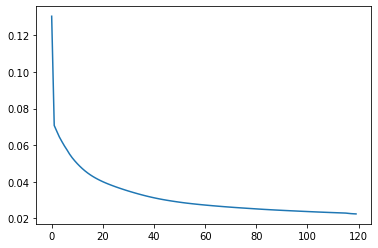

In [93]:
plt.plot(range(len(losslist)),losslist)

[3190, 1561, 5866, 9606, 9304, 5237]
Elapsed: 0.51ms
Elapsed: 4.52ms
Elapsed: 0.66ms
Elapsed: 0.79ms
Elapsed: 0.41ms
Elapsed: 0.37ms


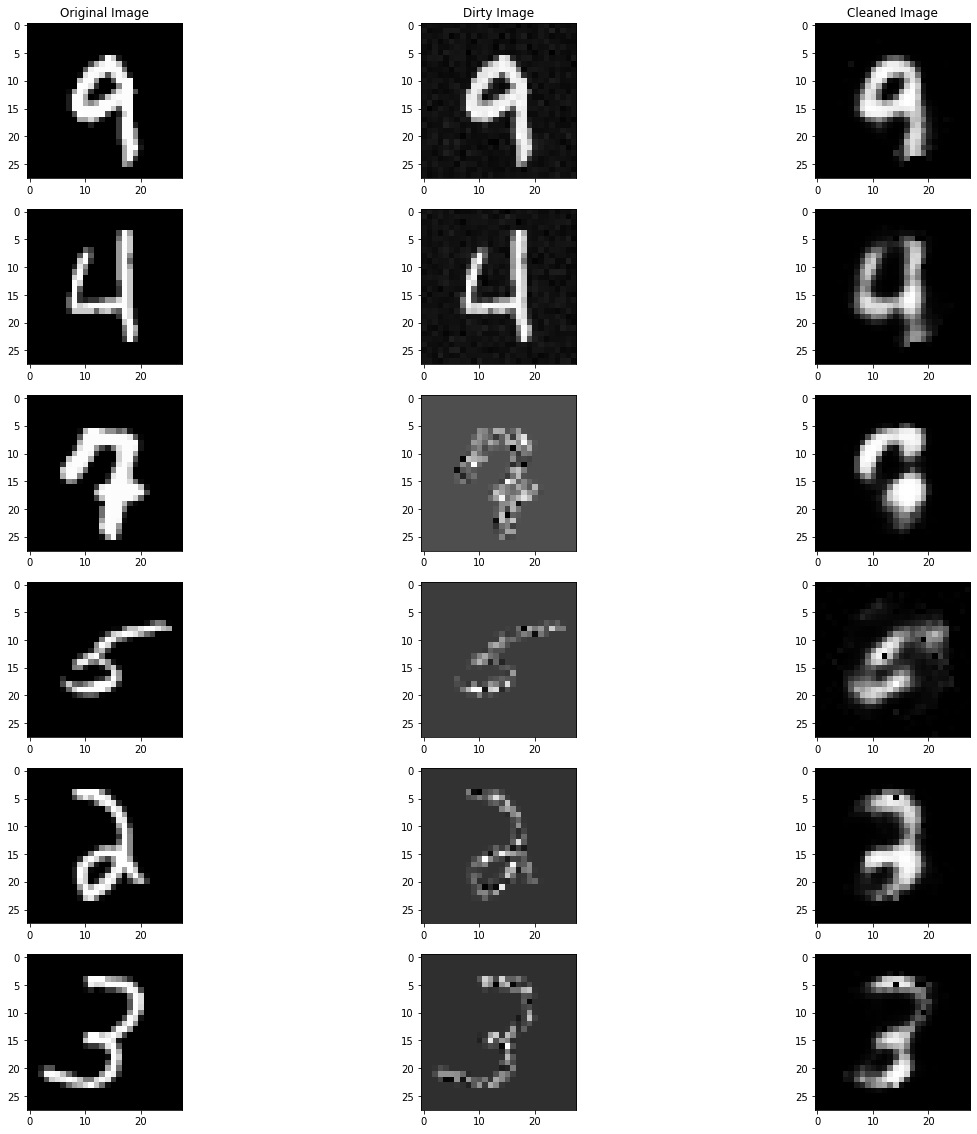

In [101]:
"""Here, we try to visualize some of the results.
  We randomly generate 6 numbers in between 1 and 10k , run them through the model,
  and show the results with comparisons
  
 """
import time

device='cpu'
model.to(device)

f,axes= plt.subplots(6,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")
#test_imgs=np.random.randint(0,10000,size=6)
test_imgs = [3190, 1561, 5866, 9606, 9304, 5237]
print(test_imgs)

for idx in range((6)):
  dirty=testset[test_imgs[idx]][0]
  clean=testset[test_imgs[idx]][1]
  label=testset[test_imgs[idx]][2]
  dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
  dirty=dirty.to(device)

  t = time.time()
  output=model(dirty)
  print(f'Elapsed: {(time.time() - t) * 1000:.2f}ms')
  
  output=output.view(1,28,28)
  output=output.permute(1,2,0).squeeze(2)
  output=output.detach().cpu().numpy()
  
  dirty=dirty.view(1,28,28)
  dirty=dirty.permute(1,2,0).squeeze(2)
  dirty=dirty.detach().cpu().numpy()
  
  clean=clean.permute(1,2,0).squeeze(2)
  clean=clean.detach().cpu().numpy()
  
  axes[idx,0].imshow(clean,cmap="gray")
  axes[idx,1].imshow(dirty,cmap="gray")
  axes[idx,2].imshow(output,cmap="gray")
  
  
  
  
  

In [97]:
PATH="training/denoising_1.pth"
torch.save(model,PATH)  # We save the model state dict at PATH   